<a href="https://www.kaggle.com/code/klyushnik/regression-with-an-insurance-dataset-ensemble?scriptVersionId=211330873" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv
/kaggle/input/insurance-premium-prediction/README.md
/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv


# - Description


![The-role-of-data-analytics-in-insurance.png](https://innowise.com/wp-content/uploads/2023/12/The-role-of-data-analytics-in-insurance.png)

The old discription: The goal of this dataset is to facilitate the development and testing of regression models for predicting insurance premiums based on various customer characteristics and policy details. Insurance companies often rely on data-driven approaches to estimate premiums, taking into account factors such as age, income, health status, and claim history. This synthetic dataset simulates real-world scenarios to help practitioners practice feature engineering, data cleaning, and model training.
https://www.kaggle.com/code/gauravduttakiit/org-pss4e1

**Evaluation**

Submissions are evaluated using the Root Mean Squared Logarithmic Error (RMSLE).

![kaggle-forum-message-attachments/o/inbox%2F8418027%2Fcddd759e4dd26007634bcd01c2ea8a42%2FScreenshot%202024-01-10%20135652.png?generation=1704873450127348&alt=media](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F8418027%2Fcddd759e4dd26007634bcd01c2ea8a42%2FScreenshot%202024-01-10%20135652.png?generation=1704873450127348&alt=media)

# - Welcome

Welcome to my github - https://github.com/Alexsandrrus/projekts-Kaggle

# - Libraries

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import re
from scipy import stats

import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import keras_tuner
import optuna
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

from keras import layers
from keras.layers import (BatchNormalization, Dense, Dropout, 
                           Flatten, Activation)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import (IsolationForest, 
                              VotingRegressor)
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (KFold, StratifiedKFold, 
                                     StratifiedGroupKFold, 
                                     RepeatedStratifiedKFold, 
                                     RepeatedKFold, 
                                     train_test_split, 
                                     cross_validate)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, 
                                   MinMaxScaler, PowerTransformer, 
                                   QuantileTransformer, 
                                   RobustScaler, StandardScaler)
from sklearn.feature_selection import VarianceThreshold

plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None

import warnings

warnings.filterwarnings("ignore")

In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)')
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features])
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            # Получаем топ-N категорий
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i])  # Используем y для горизонтального графика
        else:
            sns.countplot(data=df, y=feature, ax=axes[i])  # Используем y для горизонтального графика
        
        axes[i].set_title(f'Count of {feature}')
        axes[i].tick_params(axis='y', rotation=0)  # Поворачиваем метки по оси Y для лучшей читаемости

    # Убираем пустые подграфики, если они есть
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    
def day_part(hour):
    if hour in [4,5]:
        return 1
    elif hour in [6,7]:
        return 2
    elif hour in [8,9,10]:
        return 3
    elif hour in [11,12,13]:
        return 4
    elif hour in [14,15,16]:
        return 5
    elif hour in [17, 18,19]:
        return 6
    elif hour in [20, 21, 22]:
        return 7
    elif hour in [23,0,1,2,3]:
        return 0

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
# Function optimizes memory usage in dataframe.

# Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

# - Load data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
org=pd.read_csv('/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv')

train.shape, test.shape, org.shape

((1200000, 21), (800000, 20), (278860, 20))

In [5]:
org=org[~org['Premium Amount'].isnull()]
train = pd.concat([train, org], ignore_index=True)
train= train.reset_index(drop=True)
train.shape

(1477019, 21)

In [6]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)
org = optimize_memory_usage(org)

Memory usage size: before 236.6441 Mb - after 180.3003 Mb (23.8%).
Memory usage size: before 122.0704 Mb - after 94.6046 Mb (22.5%).
Memory usage size: before 44.3832 Mb - after 33.2874 Mb (25.0%).


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477019 entries, 0 to 1477018
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  float32
 1   Age                   1453656 non-null  float32
 2   Gender                1477019 non-null  object 
 3   Annual Income         1418219 non-null  float32
 4   Marital Status        1453499 non-null  object 
 5   Number of Dependents  1339658 non-null  float32
 6   Education Level       1477019 non-null  object 
 7   Occupation            1038196 non-null  object 
 8   Health Score          1392418 non-null  float32
 9   Location              1477019 non-null  object 
 10  Policy Type           1477019 non-null  object 
 11  Previous Claims       1032241 non-null  float32
 12  Vehicle Age           1477013 non-null  float32
 13  Credit Score          1311437 non-null  float32
 14  Insurance Duration    1477018 non-

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1200000.0,599999.812500,346410.312500,0.000000,299999.750000,599999.500000,899999.250000,1.199999e+06
Age,1453656.0,41.122074,13.541599,18.000000,29.000000,41.000000,53.000000,6.400000e+01
Annual Income,1418219.0,34480.187500,33010.402344,0.000000,9063.000000,24996.000000,46303.000000,1.499970e+05
Number of Dependents,1339658.0,2.007762,1.416408,0.000000,1.000000,2.000000,3.000000,4.000000e+00
Health Score,1392418.0,26.182304,13.059947,0.035436,15.937015,24.849262,35.235943,9.387609e+01
Previous Claims,1032241.0,1.001817,0.986276,0.000000,0.000000,1.000000,2.000000,9.000000e+00
Vehicle Age,1477013.0,9.560404,5.774580,0.000000,5.000000,10.000000,15.000000,1.900000e+01
Credit Score,1311437.0,589.400574,151.871002,300.000000,463.000000,591.000000,719.000000,8.490000e+02
Insurance Duration,1477018.0,5.016284,2.591927,1.000000,3.000000,5.000000,7.000000,9.000000e+00
Premium Amount,1477019.0,1076.958008,875.120850,0.000000,468.000000,837.000000,1484.000000,4.999000e+03


**Descriptive statistics of the average client: man or woman 40+ years old, with an average income of 30 thousand+ $, with two children, a car over 9 years old, with a slightly lower credit rating, insured for about 5 years**

In [9]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 19%
Age - 2%
Gender - 0%
Annual Income - 4%
Marital Status - 2%
Number of Dependents - 9%
Education Level - 0%
Occupation - 30%
Health Score - 6%
Location - 0%
Policy Type - 0%
Previous Claims - 30%
Vehicle Age - 0%
Credit Score - 11%
Insurance Duration - 0%
Policy Start Date - 0%
Customer Feedback - 7%
Smoking Status - 0%
Exercise Frequency - 0%
Property Type - 0%
Premium Amount - 0%


In [10]:
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

In [11]:
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '_', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '_', x))

In [12]:
train.Policy_Start_Date=pd.to_datetime(train.Policy_Start_Date, infer_datetime_format=True)
test.Policy_Start_Date=pd.to_datetime(test.Policy_Start_Date, infer_datetime_format=True)

In [13]:
train['Policy_Start_Date:year'] = train['Policy_Start_Date'].dt.year
train['Policy_Start_Date:month'] = train['Policy_Start_Date'].dt.month
train['Policy_Start_Date:day'] = train['Policy_Start_Date'].dt.day
train['Policy_Start_Date:day_of_week'] = train['Policy_Start_Date'].dt.day_of_week
train['Policy_Start_Date:day_of_year'] = train['Policy_Start_Date'].dt.day_of_year
train['Policy_Start_Date:is_year_start'] = train['Policy_Start_Date'].dt.is_year_start
train['Policy_Start_Date:is_quarter_start'] = train['Policy_Start_Date'].dt.is_quarter_start
train['Policy_Start_Date:is_year_end'] = train['Policy_Start_Date'].dt.is_year_end
train['Policy_Start_Date:is_quarter_end'] = train['Policy_Start_Date'].dt.is_quarter_end
train['Policy_Start_Date:is_month_start'] = train['Policy_Start_Date'].dt.is_month_start
train['Policy_Start_Date:is_month_end'] = train['Policy_Start_Date'].dt.is_month_end
train['Policy_Start_Date:is_weekend'] = np.where(train['Policy_Start_Date:day_of_week'].isin([5,6]), 1,0)
train['Policy_Start_Date:hour'] = train['Policy_Start_Date'].dt.hour
train['Policy_Start_Date:minute'] = train['Policy_Start_Date'].dt.minute
train['Policy_Start_Date:second'] = train['Policy_Start_Date'].dt.second
train['Policy_Start_Date:day_part'] = train['Policy_Start_Date:hour'].apply(day_part)
train[['Policy_Start_Date:is_month_end', 'Policy_Start_Date:is_month_start',
       'Policy_Start_Date:is_quarter_end', 'Policy_Start_Date:is_quarter_start',
       'Policy_Start_Date:is_year_end', 'Policy_Start_Date:is_year_start']]=train[['Policy_Start_Date:is_month_end', 'Policy_Start_Date:is_month_start',
       'Policy_Start_Date:is_quarter_end', 'Policy_Start_Date:is_quarter_start',
       'Policy_Start_Date:is_year_end', 'Policy_Start_Date:is_year_start']].replace({True:1,False:0})
train=train.drop(['Policy_Start_Date'],axis=1)

test['Policy_Start_Date:year'] = test['Policy_Start_Date'].dt.year
test['Policy_Start_Date:month'] = test['Policy_Start_Date'].dt.month
test['Policy_Start_Date:day'] = test['Policy_Start_Date'].dt.day
test['Policy_Start_Date:day_of_week'] = test['Policy_Start_Date'].dt.day_of_week
test['Policy_Start_Date:day_of_year'] = test['Policy_Start_Date'].dt.day_of_year
test['Policy_Start_Date:is_year_start'] = test['Policy_Start_Date'].dt.is_year_start
test['Policy_Start_Date:is_quarter_start'] = test['Policy_Start_Date'].dt.is_quarter_start
test['Policy_Start_Date:is_year_end'] = test['Policy_Start_Date'].dt.is_year_end
test['Policy_Start_Date:is_quarter_end'] = test['Policy_Start_Date'].dt.is_quarter_end
test['Policy_Start_Date:is_month_start'] = test['Policy_Start_Date'].dt.is_month_start
test['Policy_Start_Date:is_month_end'] = test['Policy_Start_Date'].dt.is_month_end
test['Policy_Start_Date:is_weekend'] = np.where(test['Policy_Start_Date:day_of_week'].isin([5,6]), 1,0)
test['Policy_Start_Date:hour'] = test['Policy_Start_Date'].dt.hour
test['Policy_Start_Date:minute'] = test['Policy_Start_Date'].dt.minute
test['Policy_Start_Date:second'] = test['Policy_Start_Date'].dt.second
test['Policy_Start_Date:day_part'] = test['Policy_Start_Date:hour'].apply(day_part)
test[['Policy_Start_Date:is_month_end', 'Policy_Start_Date:is_month_start',
       'Policy_Start_Date:is_quarter_end', 'Policy_Start_Date:is_quarter_start',
       'Policy_Start_Date:is_year_end', 'Policy_Start_Date:is_year_start']]=test[['Policy_Start_Date:is_month_end', 'Policy_Start_Date:is_month_start',
       'Policy_Start_Date:is_quarter_end', 'Policy_Start_Date:is_quarter_start',
       'Policy_Start_Date:is_year_end', 'Policy_Start_Date:is_year_start']].replace({True:1,False:0})
test=test.drop(['Policy_Start_Date'],axis=1)

train.shape, test.shape

((1477019, 35), (800000, 34))

https://www.kaggle.com/code/gauravduttakiit/org-pss4e12-dataset  - Thanks for great ideas

# - EDA

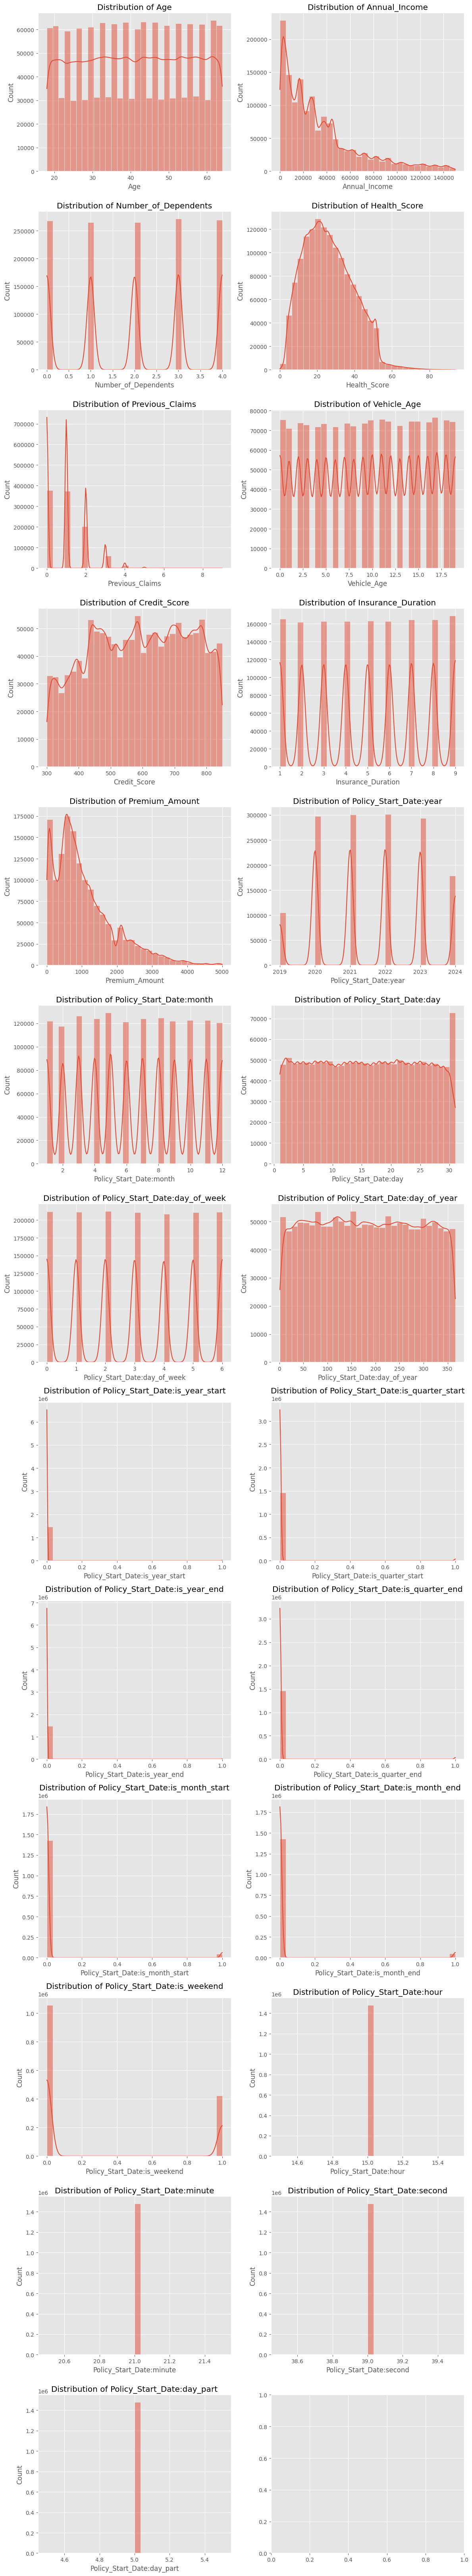

In [14]:
plot_numerical_features(train)

**Data is biased. We need to tune the model so that it is possible to predict low and medium values**

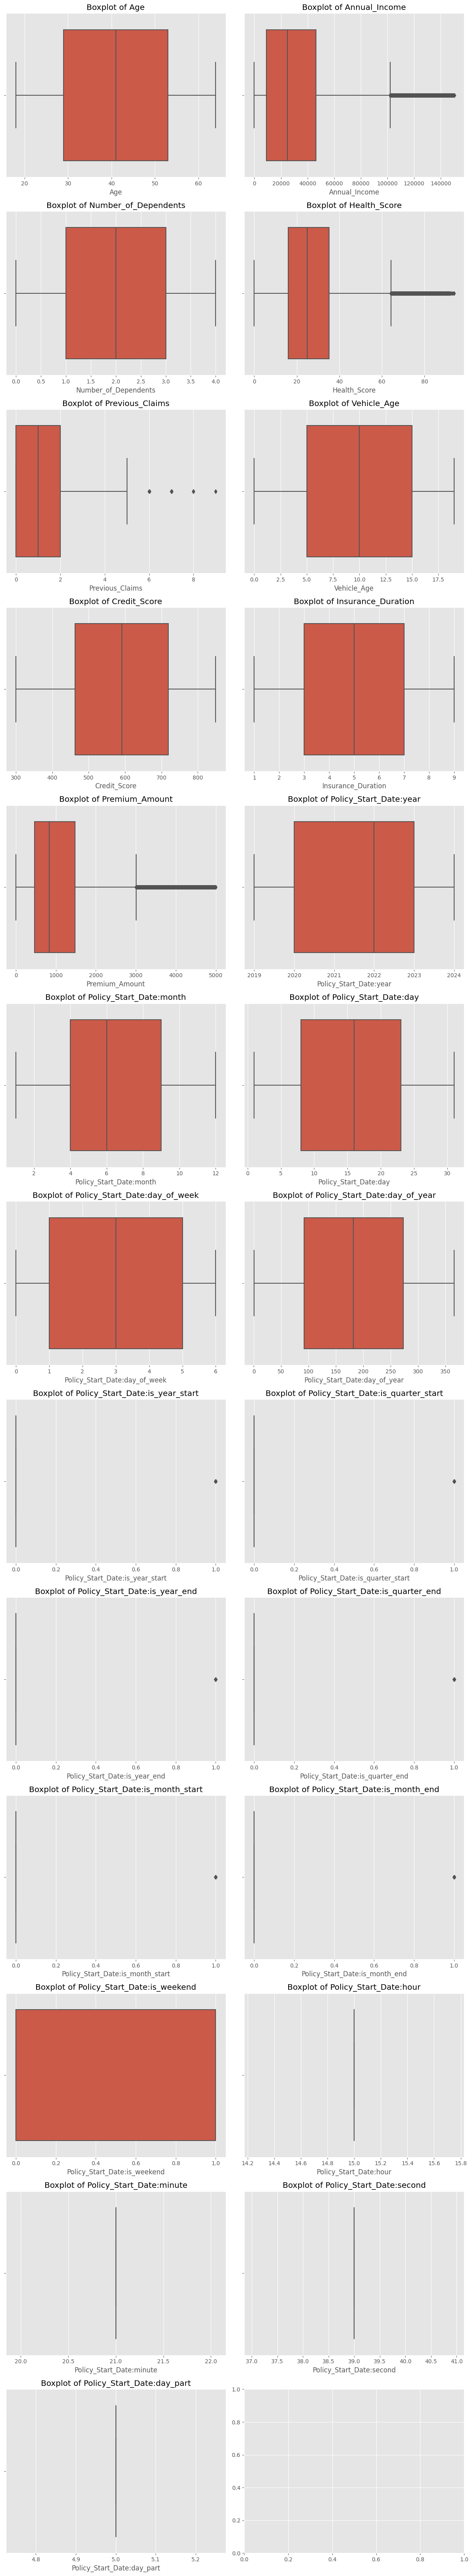

In [15]:
plot_numerical_boxplots(train)

**The boxplot shows the distribution that there are outliers, but they are more representative of insurance premiums.**

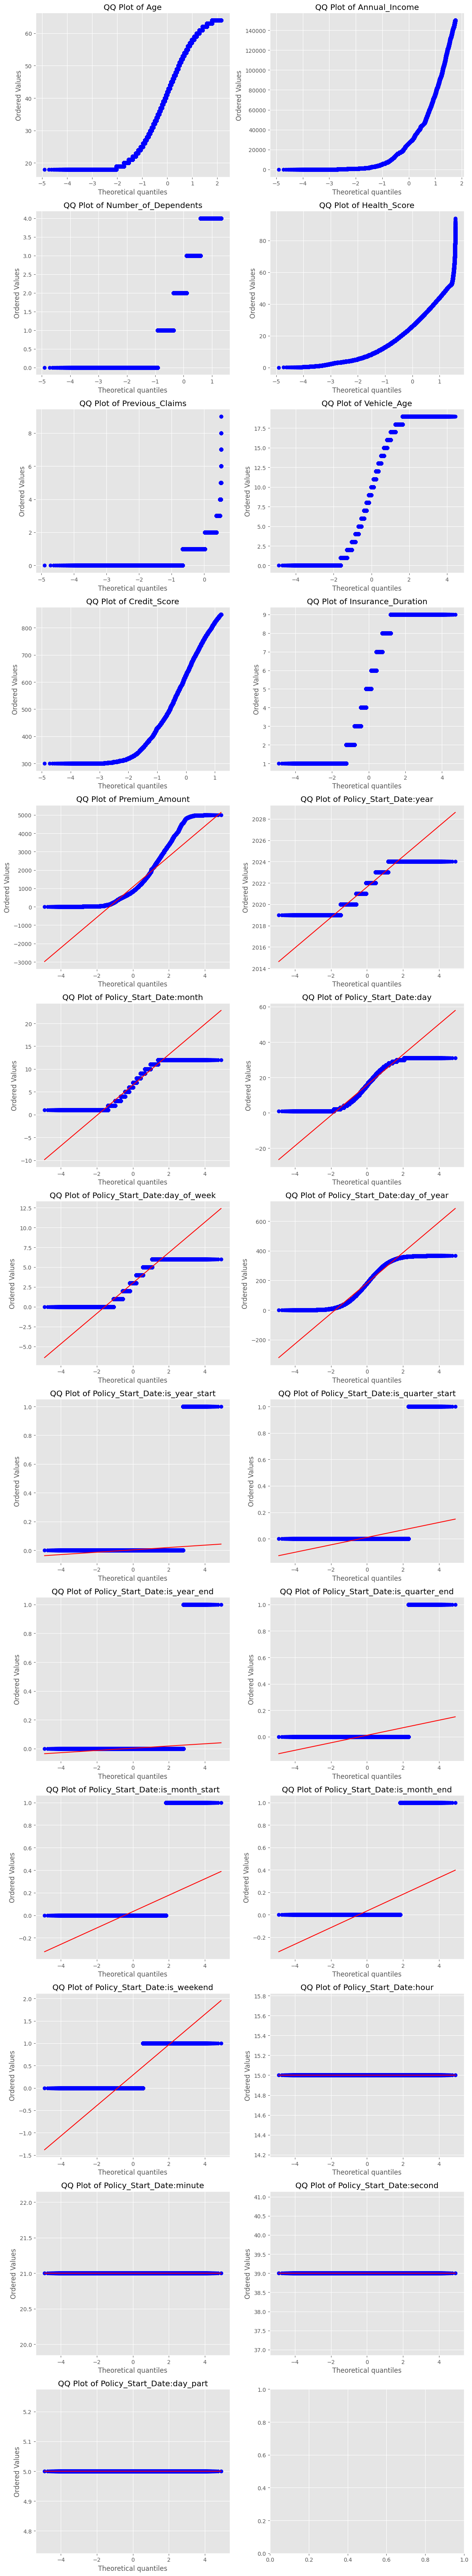

In [16]:
plot_qq_plot(train)

**The quantile-quantile plot for uniform and bimodal distributions represents an S - Shaped curve. In the case of a uniform distribution, the curve spreads along the main trend line, and in the case of a bimodal distribution, it intersects it. I also draw your attention to the behavior of the letter S at zero in the case of a bimodal distribution. If the gap between the humps is large, then the quantile dependence in this place becomes almost vertical.**

In [17]:
# plot_pairplot(train)

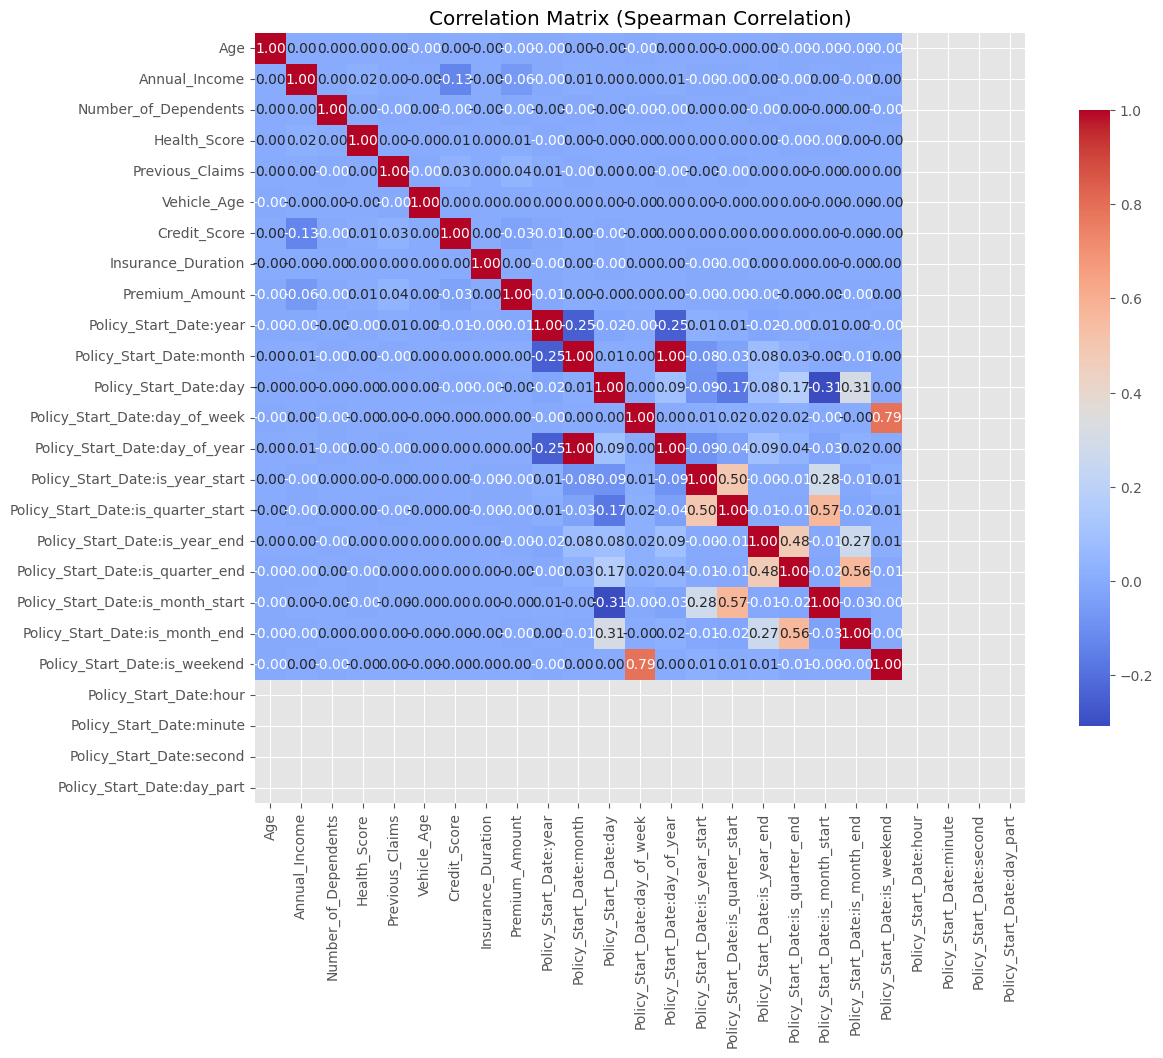

In [18]:
plot_correlation_matrix(train)

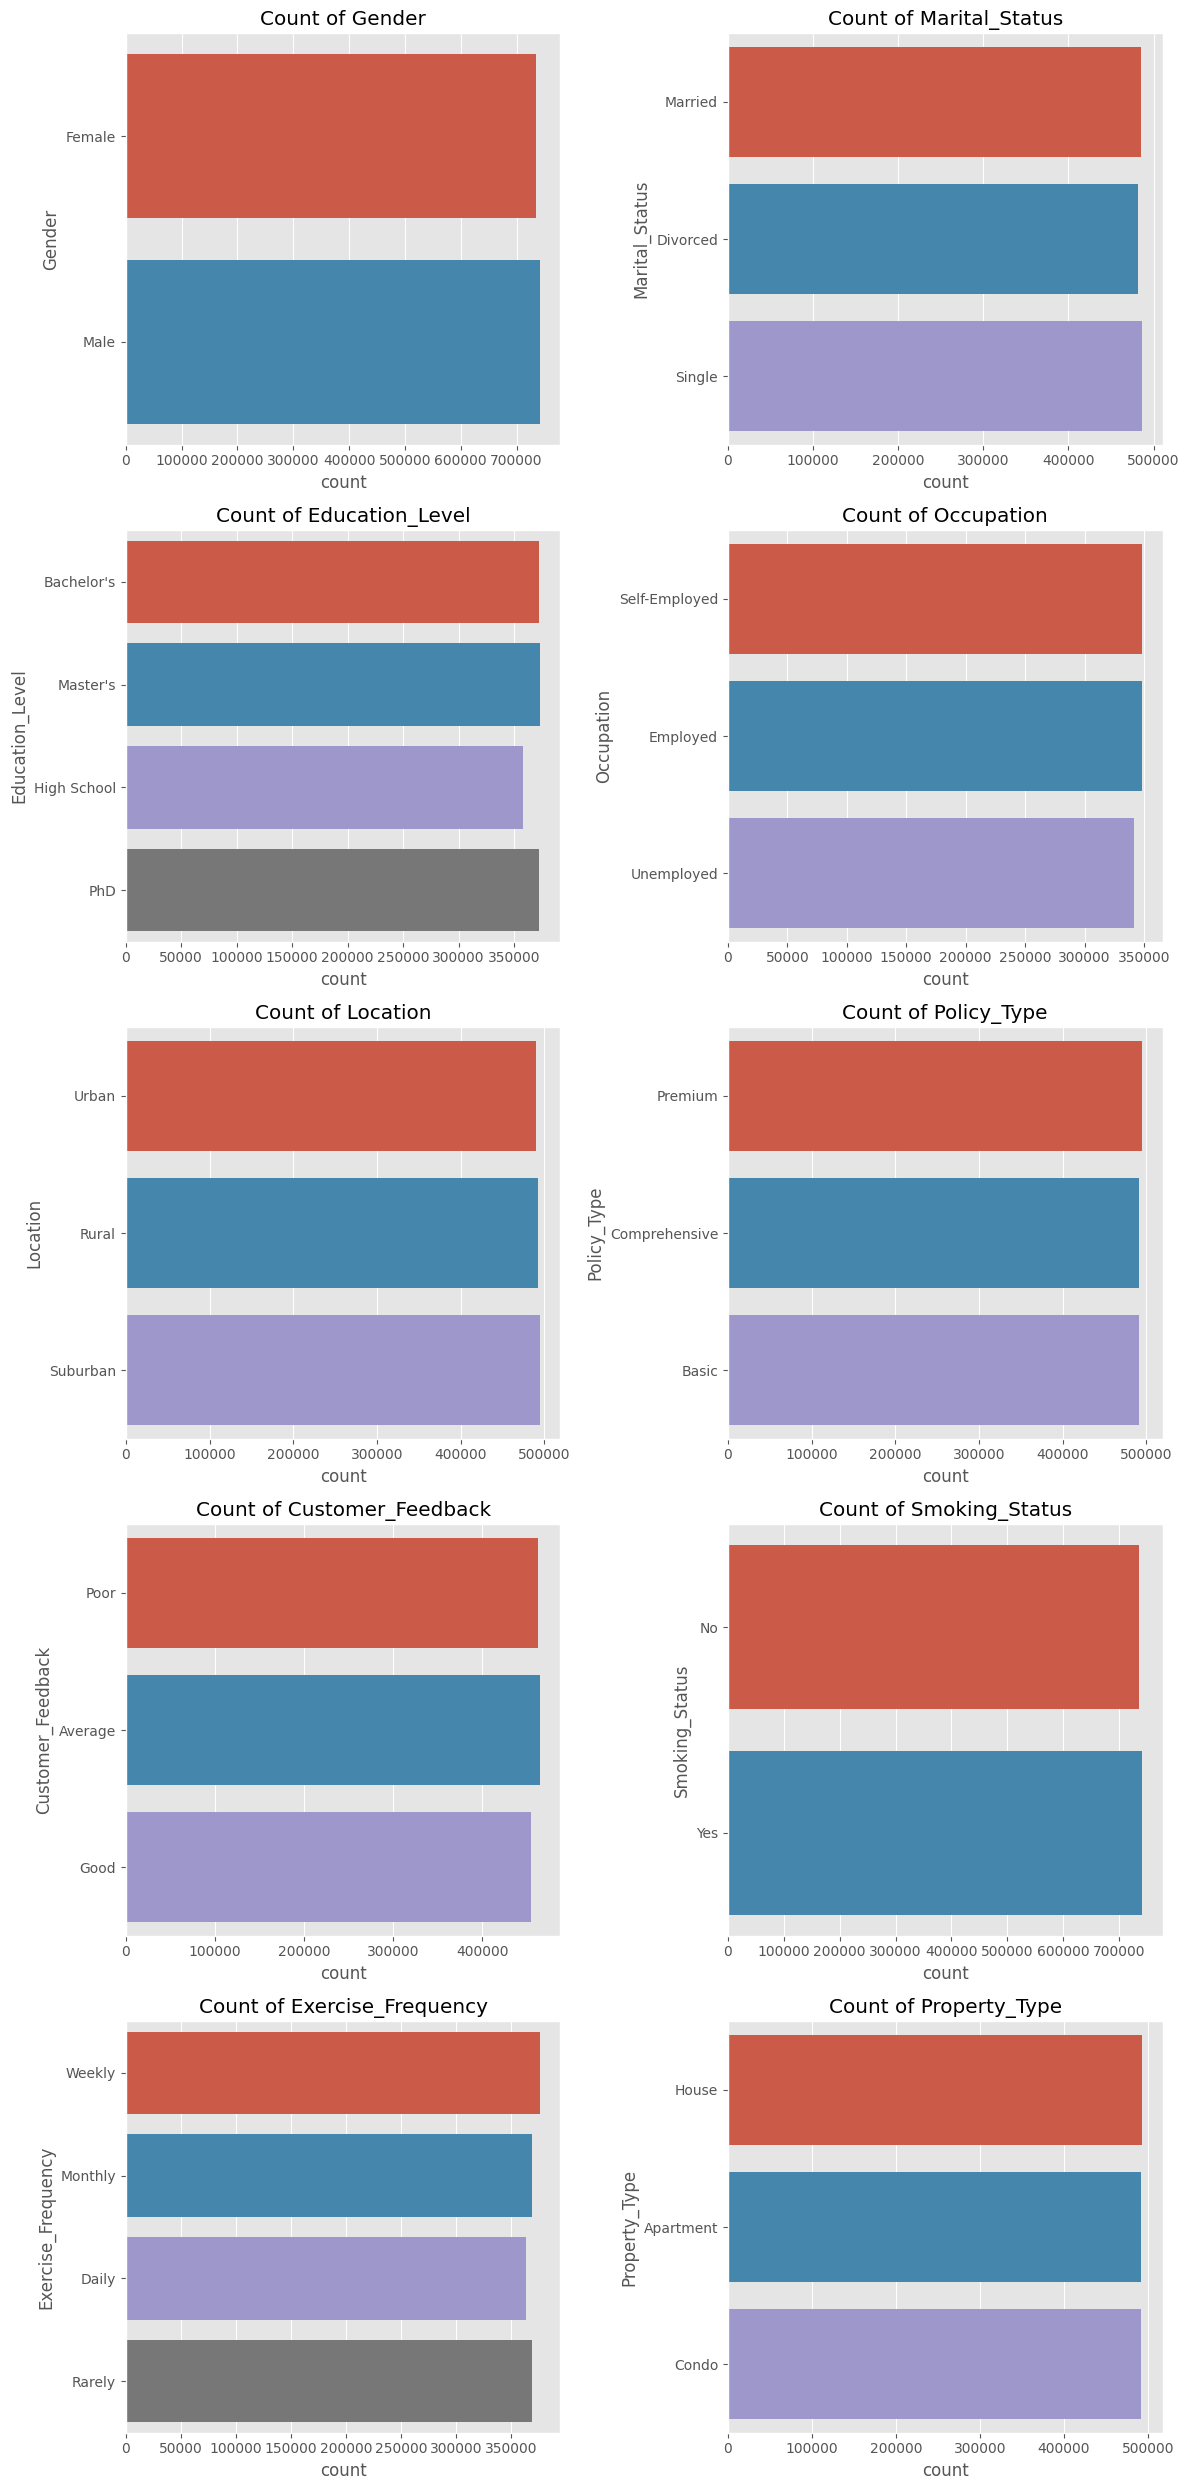

In [19]:
plot_categorical_features(train)

**The data is very balanced**